## 1: Data Gathering

In [3]:
import requests
import pandas as pd
import time
import numpy as np
import re
import os
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from collections import Counter
from scipy.sparse.linalg import svds
import datetime
import ast

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\Aayush
[nltk_data]     Pradhan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Aayush
[nltk_data]     Pradhan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
MIND_TRAIN_FOLDER = "MINDlarge_train"
MIND_TEST_FOLDER = "MINDlarge_test"
MIND_DEV_FOLDER = "MINDlarge_dev"

In [5]:
news_df = pd.read_csv(os.path.join(MIND_TRAIN_FOLDER, "news.tsv"), sep="\t", header=None)

# Assign column names based on MIND documentation
news_df.columns = ["news_id", "category", "subcategory", "title", "abstract", "url", "title_entities", "abstract_entities"]
news_df.head()

,news_id,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,N88753,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N45436,news,newsscienceandtechnology,Walmart Slashes Prices on Last-Generation iPads,Apple's new iPad releases bring big deals on l...,https://assets.msn.com/labs/mind/AABmf2I.html,"[{""Label"": ""IPad"", ""Type"": ""J"", ""WikidataId"": ...","[{""Label"": ""IPad"", ""Type"": ""J"", ""WikidataId"": ..."
2,N23144,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
3,N86255,health,medical,Dispose of unwanted prescription drugs during ...,NaN,https://assets.msn.com/labs/mind/AAISxPN.html,"[{""Label"": ""Drug Enforcement Administration"", ...",[]
4,N93187,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."


In [6]:
news_df.to_csv("MIND_large_articles.csv", index=False)
print("✅ Data saved to MIND_large_articles.csv")

✅ Data saved to MIND_large_articles.csv


## 2: Data Loading & Preprocessing

In [7]:
news_df = pd.read_csv("MIND_large_articles.csv")
news_df.head()

,news_id,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,N88753,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N45436,news,newsscienceandtechnology,Walmart Slashes Prices on Last-Generation iPads,Apple's new iPad releases bring big deals on l...,https://assets.msn.com/labs/mind/AABmf2I.html,"[{""Label"": ""IPad"", ""Type"": ""J"", ""WikidataId"": ...","[{""Label"": ""IPad"", ""Type"": ""J"", ""WikidataId"": ..."
2,N23144,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
3,N86255,health,medical,Dispose of unwanted prescription drugs during ...,NaN,https://assets.msn.com/labs/mind/AAISxPN.html,"[{""Label"": ""Drug Enforcement Administration"", ...",[]
4,N93187,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."


In [8]:
print("\n🔹 Checking for missing values:")
news_df.isnull().sum()


🔹 Checking for missing values:


news_id                 0
category                0
subcategory             0
title                   0
abstract             5415
url                     0
title_entities          3
abstract_entities       6
dtype: int64

Handle Missing Values

In [10]:
news_df["abstract"].fillna("No summary available", inplace=True)

# Fill missing entity columns with empty JSON-like structures
news_df["title_entities"].fillna("[]", inplace=True)
news_df["abstract_entities"].fillna("[]", inplace=True)

C:\Users\Aayush Pradhan\AppData\Local\Temp\ipykernel_11740\3447540618.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  news_df["abstract"].fillna("No summary available", inplace=True)
C:\Users\Aayush Pradhan\AppData\Local\Temp\ipykernel_11740\3447540618.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Standardize Text Fields

In [ ]:
def clean_text(text):
    text = str(text).lower()                # Convert to lowercase
    text = re.sub(r"\s+", " ", text)        # Remove extra spaces
    text = re.sub(r"[^\w\s]", "", text)     # Remove special characters
    return text.strip()

news_df["cleaned_title"] = news_df["title"].apply(clean_text)
news_df["cleaned_abstract"] = news_df["abstract"].apply(clean_text)

In [12]:
news_df["category"] = news_df["category"].str.lower()
news_df["subcategory"] = news_df["subcategory"].str.lower()

# Drop Duplicates
news_df.drop_duplicates(subset=["title", "url"], keep="first", inplace=True)

news_df.to_csv("MIND_large_cleaned.csv", index=False)

print(f"\n✅ Data Cleaning Complete! {len(news_df)} articles saved to 'MIND_large_cleaned.csv'.")
print("\n🔹 Sample Cleaned Data:")
print(news_df.head())


✅ Data Cleaning Complete! 101527 articles saved to 'MIND_large_cleaned.csv'.

🔹 Sample Cleaned Data:
  news_id   category               subcategory  \
0  N88753  lifestyle           lifestyleroyals   
1  N45436       news  newsscienceandtechnology   
2  N23144     health                weightloss   
3  N86255     health                   medical   
4  N93187       news                 newsworld   

                                               title  \
0  The Brands Queen Elizabeth, Prince Charles, an...   
1    Walmart Slashes Prices on Last-Generation iPads   
2                      50 Worst Habits For Belly Fat   
3  Dispose of unwanted prescription drugs during ...   
4  The Cost of Trump's Aid Freeze in the Trenches...   

                                            abstract  \
0  Shop the notebooks, jackets, and more that the...   
1  Apple's new iPad releases bring big deals on l...   
2  These seemingly harmless habits are holding yo...   
3                               No s

## 3: Exploratory Data Analysis (EDA)

In [13]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101527 entries, 0 to 101526
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   news_id            101527 non-null  object
 1   category           101527 non-null  object
 2   subcategory        101527 non-null  object
 3   title              101527 non-null  object
 4   abstract           101527 non-null  object
 5   url                101527 non-null  object
 6   title_entities     101527 non-null  object
 7   abstract_entities  101527 non-null  object
 8   cleaned_title      101527 non-null  object
 9   cleaned_abstract   101527 non-null  object
dtypes: object(10)
memory usage: 7.7+ MB


C:\Users\Aayush Pradhan\AppData\Local\Temp\ipykernel_11740\166069377.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=news_df["category"], order=news_df["category"].value_counts().index, palette="coolwarm")


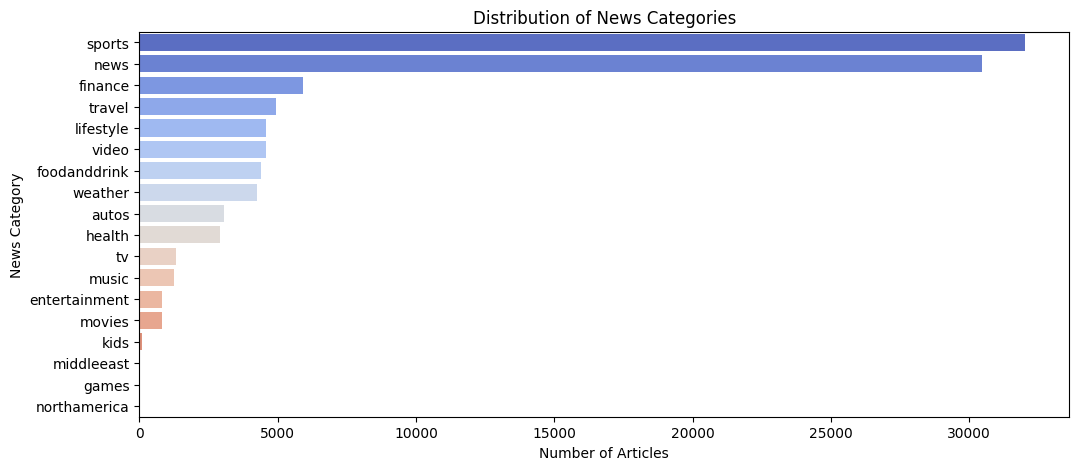

In [14]:
# --- 1️⃣ Category Distribution ---
plt.figure(figsize=(12, 5))
sns.countplot(y=news_df["category"], order=news_df["category"].value_counts().index, palette="coolwarm")
plt.xlabel("Number of Articles")
plt.ylabel("News Category")
plt.title("Distribution of News Categories")
plt.show()

C:\Users\Aayush Pradhan\AppData\Local\Temp\ipykernel_11740\2923352376.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=news_df["subcategory"], order=news_df["subcategory"].value_counts().index[:20], palette="viridis")


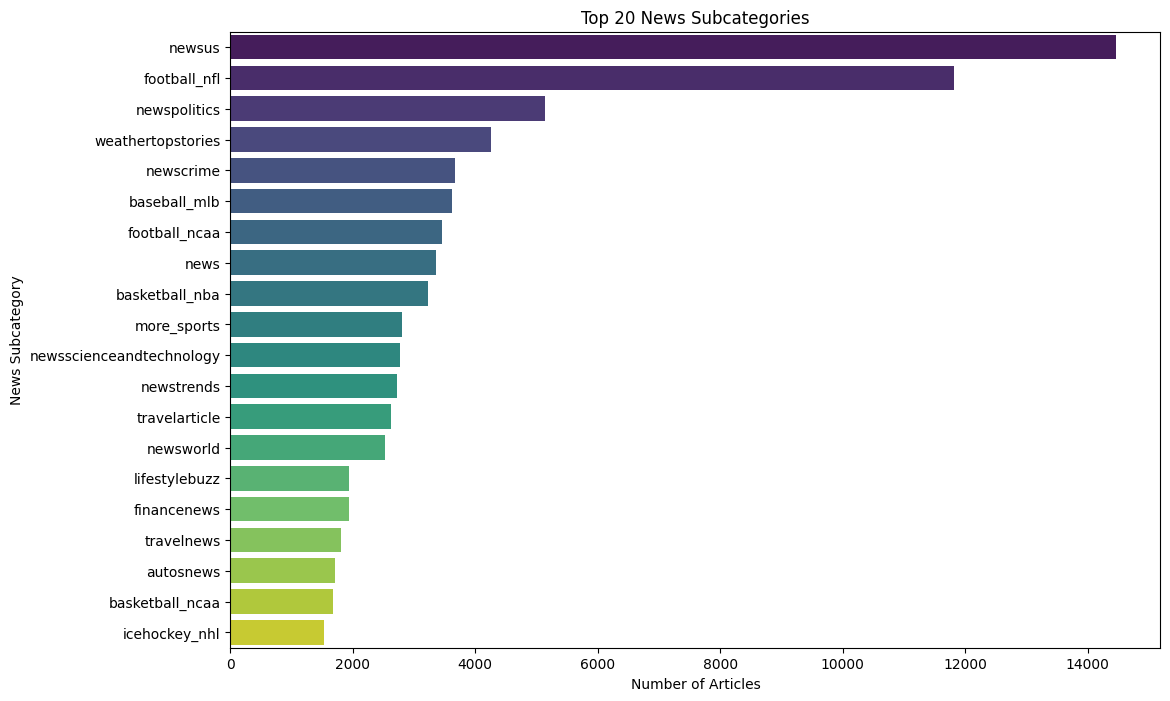

In [15]:
# --- 2️⃣ Subcategory Distribution ---
plt.figure(figsize=(12, 8))
sns.countplot(y=news_df["subcategory"], order=news_df["subcategory"].value_counts().index[:20], palette="viridis")
plt.xlabel("Number of Articles")
plt.ylabel("News Subcategory")
plt.title("Top 20 News Subcategories")
plt.show()

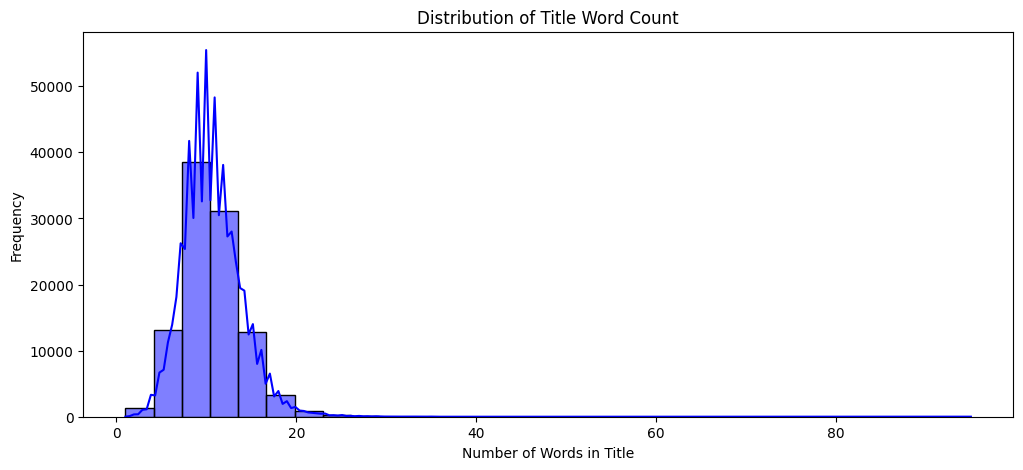

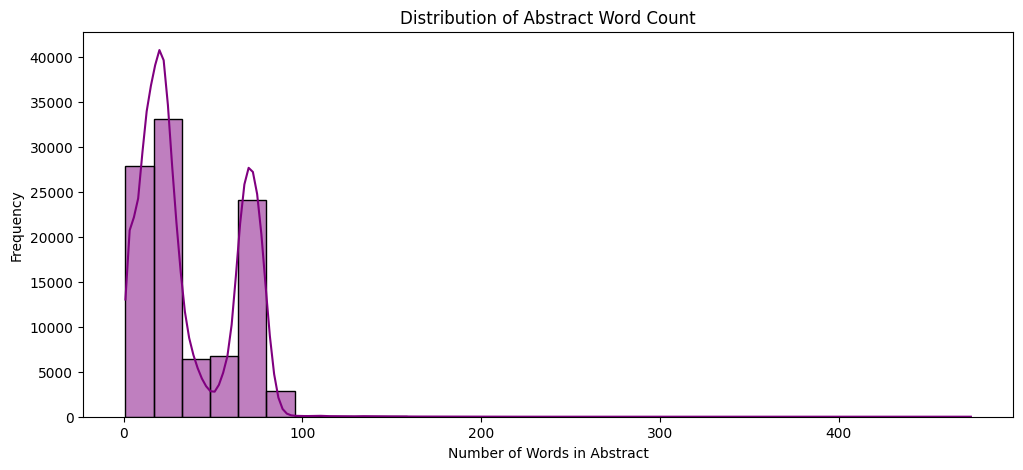

In [16]:
# --- 3️⃣ Article Length Distribution (Title & Abstract) ---
news_df["title_length"] = news_df["title"].apply(lambda x: len(str(x).split()))
news_df["abstract_length"] = news_df["abstract"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12, 5))
sns.histplot(news_df["title_length"], bins=30, kde=True, color="blue")
plt.xlabel("Number of Words in Title")
plt.ylabel("Frequency")
plt.title("Distribution of Title Word Count")
plt.show()

plt.figure(figsize=(12, 5))
sns.histplot(news_df["abstract_length"], bins=30, kde=True, color="purple")
plt.xlabel("Number of Words in Abstract")
plt.ylabel("Frequency")
plt.title("Distribution of Abstract Word Count")
plt.show()

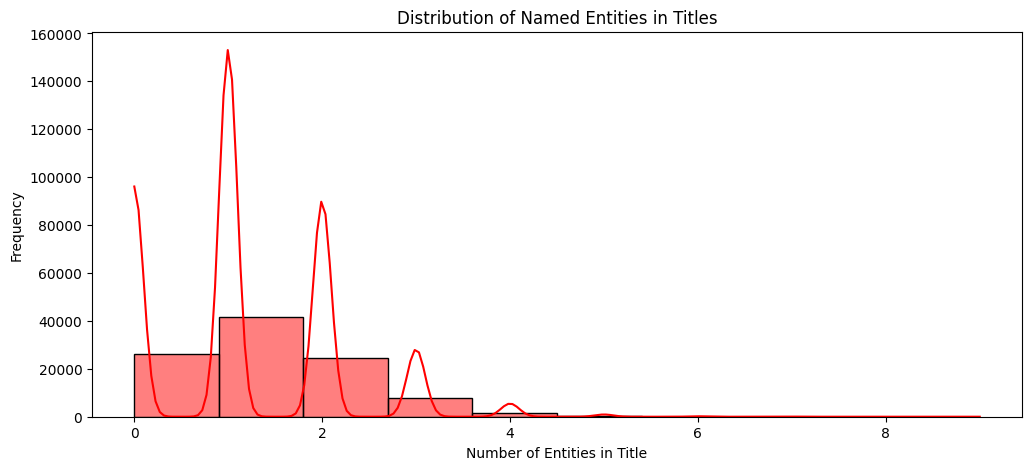

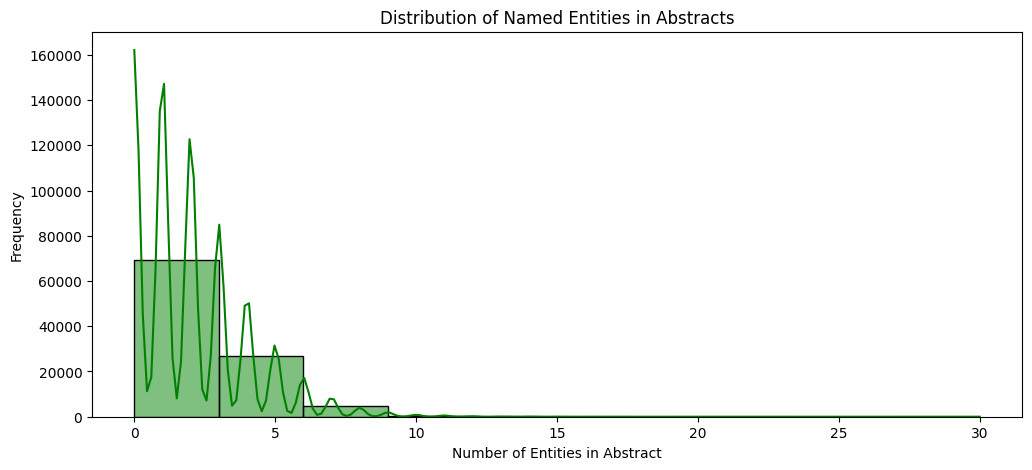

In [19]:
# --- 4️⃣ Count of Articles with Named Entities ---
news_df["title_entities_count"] = news_df["title_entities"].apply(lambda x: len(ast.literal_eval(str(x))) if x != "[]" else 0)
news_df["abstract_entities_count"] = news_df["abstract_entities"].apply(lambda x: len(ast.literal_eval(str(x))) if x != "[]" else 0)

plt.figure(figsize=(12, 5))
sns.histplot(news_df["title_entities_count"], bins=10, kde=True, color="red")
plt.xlabel("Number of Entities in Title")
plt.ylabel("Frequency")
plt.title("Distribution of Named Entities in Titles")
plt.show()

plt.figure(figsize=(12, 5))
sns.histplot(news_df["abstract_entities_count"], bins=10, kde=True, color="green")
plt.xlabel("Number of Entities in Abstract")
plt.ylabel("Frequency")
plt.title("Distribution of Named Entities in Abstracts")
plt.show()

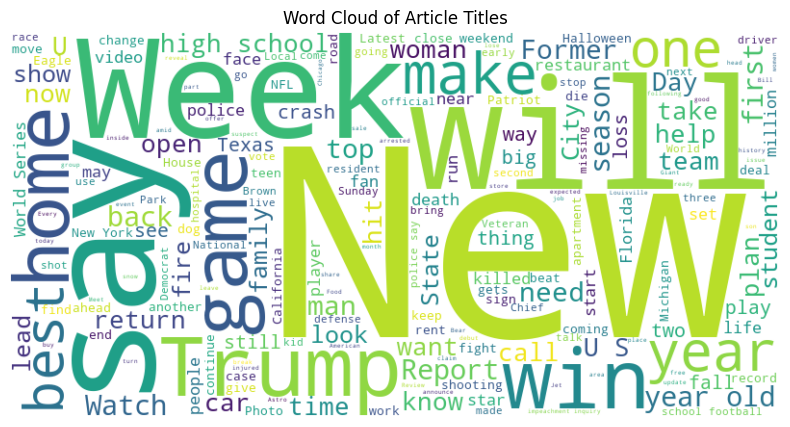

In [20]:
# --- 5️⃣ Word Cloud for Titles ---
title_text = " ".join(news_df["title"].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(title_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Article Titles")
plt.show()

C:\Users\Aayush Pradhan\AppData\Local\Temp\ipykernel_11740\2208077207.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="Word", data=common_words_df, palette="magma")


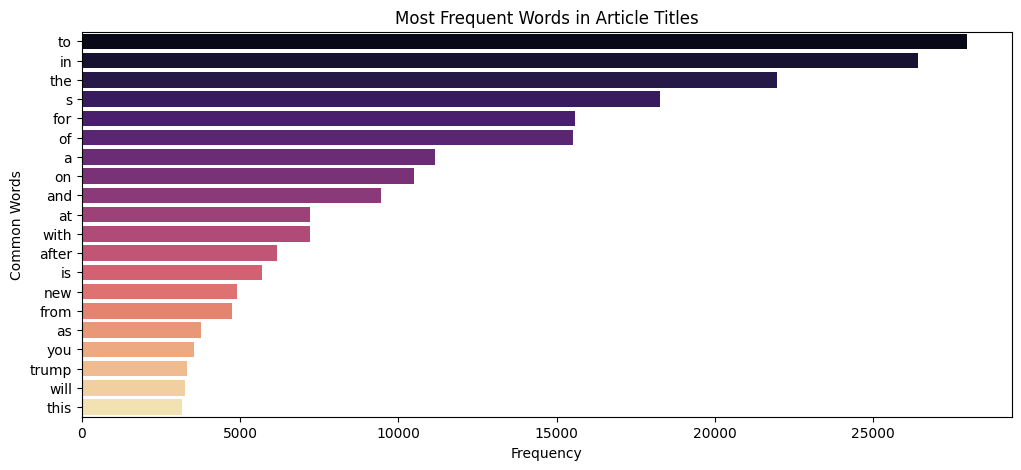

In [23]:
# --- 6️⃣ Most Common Words in Titles ---
def get_most_common_words(text_column, n=20):
    words = " ".join(text_column).lower()
    words = re.findall(r'\b\w+\b', words)  # Extract words
    common_words = Counter(words).most_common(n)
    return pd.DataFrame(common_words, columns=["Word", "Frequency"])

common_words_df = get_most_common_words(news_df["title"], 20)

plt.figure(figsize=(12, 5))
sns.barplot(x="Frequency", y="Word", data=common_words_df, palette="magma")
plt.xlabel("Frequency")
plt.ylabel("Common Words")
plt.title("Most Frequent Words in Article Titles")
plt.show()

## 4: Feature Engineering

Text Preprocessing

In [24]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"\s+", " ", text)        # Remove extra spaces
    text = re.sub(r"[^\w\s]", "", text)     # Remove special characters
    return text.strip()

news_df["cleaned_title"] = news_df["title"].apply(clean_text)
news_df["cleaned_abstract"] = news_df["abstract"].apply(clean_text)

TF-IDF Feature Extraction

In [25]:
tfidf_vectorizer = TfidfVectorizer(max_features=500)
title_tfidf = tfidf_vectorizer.fit_transform(news_df["cleaned_title"]).toarray()
title_tfidf_df = pd.DataFrame(title_tfidf, columns=[f"tfidf_{i}" for i in range(title_tfidf.shape[1])])
news_df = pd.concat([news_df, title_tfidf_df], axis=1)

Categorical Encoding

In [26]:
label_encoder_category = LabelEncoder()
news_df["category_encoded"] = label_encoder_category.fit_transform(news_df["category"])

label_encoder_subcategory = LabelEncoder()
news_df["subcategory_encoded"] = label_encoder_subcategory.fit_transform(news_df["subcategory"])

Extract Named Entity Features

In [27]:
def count_entities(entity_col):
    return entity_col.apply(lambda x: len(ast.literal_eval(str(x))) if x != "[]" else 0)

news_df["title_entities_count"] = count_entities(news_df["title_entities"])
news_df["abstract_entities_count"] = count_entities(news_df["abstract_entities"])

news_df["title_length"] = news_df["cleaned_title"].apply(lambda x: len(x.split()))
news_df["abstract_length"] = news_df["cleaned_abstract"].apply(lambda x: len(x.split()))

In [28]:
scaler = StandardScaler()
numeric_cols = ["title_length", "abstract_length", "title_entities_count", "abstract_entities_count"]
news_df[numeric_cols] = scaler.fit_transform(news_df[numeric_cols])

In [29]:
news_df.to_csv("MIND_large_featured.csv", index=False)
print(f"\n✅ Feature Engineering Complete! {len(news_df)} articles saved to 'MIND_large_featured.csv'.")


✅ Feature Engineering Complete! 101527 articles saved to 'MIND_large_featured.csv'.


## 5: Train-Test-Validation Split

In [30]:
news_df = pd.read_csv("MIND_large_featured.csv")
news_df.dropna(inplace=True)

In [ ]:
category_counts = news_df["category_encoded"].value_counts()
valid_categories = category_counts[category_counts >= 5].index  # Minimum 5 samples per category
news_df = news_df[news_df["category_encoded"].isin(valid_categories)]

feature_cols = [col for col in news_df.columns if col.startswith("tfidf_") or col in ["title_length", "abstract_length", "title_entities_count", "abstract_entities_count"]]
X = news_df[feature_cols]
y = news_df["category_encoded"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)


In [36]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [37]:
train_data = pd.DataFrame(X_train_scaled, columns=feature_cols)
train_data["target"] = y_train.values
train_data.to_csv("train_data.csv", index=False)

val_data = pd.DataFrame(X_val_scaled, columns=feature_cols)
val_data["target"] = y_val.values
val_data.to_csv("val_data.csv", index=False)

test_data = pd.DataFrame(X_test_scaled, columns=feature_cols)
test_data["target"] = y_test.values
test_data.to_csv("test_data.csv", index=False)

print(f"\n✅ Train-Test-Validation Split Complete!")
print(f"Train Set: {len(X_train)} samples")
print(f"Validation Set: {len(X_val)} samples")
print(f"Test Set: {len(X_test)} samples")


✅ Train-Test-Validation Split Complete!
Train Set: 71061 samples
Validation Set: 15227 samples
Test Set: 15228 samples


## 6: Model Selection & Training

Content-Based Filtering (Using Sparse Matrices & Nearest Neighbors)

In [40]:
train_df = pd.read_csv("train_data.csv")
test_df = pd.read_csv("test_data.csv")

# Extract features (TF-IDF columns)
feature_cols = [col for col in train_df.columns if col.startswith("tfidf_")]
X_train = csr_matrix(train_df[feature_cols].values)  # Convert to sparse matrix
X_test = csr_matrix(test_df[feature_cols].values)

# --- 1️⃣ Use Nearest Neighbors (Memory Efficient) ---
knn = NearestNeighbors(n_neighbors=5, metric="cosine", algorithm="brute")
knn.fit(X_train)

# Function to get similar articles efficiently
def get_similar_articles(article_index, top_n=5):
    distances, indices = knn.kneighbors(X_train[article_index], n_neighbors=top_n+1)
    similar_indices = indices.flatten()[1:]  # Exclude self-match
    return train_df.iloc[similar_indices][["target"]]

## 7: Model Evaluation

Improved Model Using Word2Vec

In [51]:
path = "GoogleNews-vectors-negative300.bin.gz"
print("Loading Word2Vec model...")
w2v_model = KeyedVectors.load_word2vec_format(path, binary=True, limit=20000)
print("✅ Word2Vec model loaded successfully!")

# Convert Sentences to Word2Vec Vectors
def sentence_to_vec(sentence, model, embedding_dim=300):
    words = sentence.split()
    word_vectors = [model[word] for word in words if word in model.key_to_index] 
    if len(word_vectors) == 0:
        return np.zeros(embedding_dim) 
    return np.mean(word_vectors, axis=0) 

print("Computing Word2Vec embeddings for articles...")
news_df["title_vector"] = news_df["cleaned_title"].apply(lambda x: sentence_to_vec(x, w2v_model))
print("✅ Embeddings computed!")

X_vectors = np.vstack(news_df["title_vector"].values)  

# Nearest Neighbors Model
knn = NearestNeighbors(n_neighbors=5, metric="cosine", algorithm="brute")
knn.fit(X_vectors)  
print("✅ Nearest Neighbors model trained successfully!")

# Get Similar Articles
def get_similar_articles(article_index, top_n=5):
    distances, indices = knn.kneighbors([X_vectors[article_index]], n_neighbors=top_n+1)
    similar_indices = indices.flatten()[1:]  
    return news_df.iloc[similar_indices][["title", "category"]]

Loading Word2Vec model...
✅ Word2Vec model loaded successfully!
Computing Word2Vec embeddings for articles...
✅ Embeddings computed!
✅ Nearest Neighbors model trained successfully!


In [52]:
def evaluate_recommendations(X_vectors, y_test, k=5):
    precision_scores = []
    recall_scores = []

    for i in range(len(y_test)):
        distances, indices = knn.kneighbors([X_vectors[i]], n_neighbors=k+1)
        recommended_articles = news_df.iloc[indices.flatten()[1:]]["category"].values  
        relevant_articles = [y_test[i]] 

        precision = len(set(recommended_articles) & set(relevant_articles)) / k
        recall = len(set(recommended_articles) & set(relevant_articles)) / len(relevant_articles)

        precision_scores.append(precision)
        recall_scores.append(recall)

    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)

    return avg_precision, avg_recall

precision_at_5, recall_at_5 = evaluate_recommendations(X_vectors, news_df["category"].values, k=5)

print(f"\n✅ Model Evaluation Complete!")
print(f"Precision@5: {precision_at_5:.4f}")
print(f"Recall@5: {recall_at_5:.4f}")


✅ Model Evaluation Complete!
Precision@5: 0.1698
Recall@5: 0.8492


- Precision: 0.1698 → 16.98% of the top 5 recommendations were actually relevant.
- Recall: 0.8492 → The model retrieved 84.92% of relevant recommendations among the possible correct ones.

BERT (SBERT)

In [54]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.neighbors import NearestNeighbors


print("Loading BERT (Sentence-BERT) model...")
sbert_model = SentenceTransformer('all-MiniLM-L6-v2') 
print("✅ BERT model loaded successfully!")

# Convert Titles to Sentence Embeddings
print("Computing BERT embeddings for news articles...")
news_df["title_vector"] = news_df["cleaned_title"].apply(lambda x: sbert_model.encode(x))

X_vectors = np.vstack(news_df["title_vector"].values)

print("✅ BERT embeddings computed!")

# Train Nearest Neighbors Model on BERT Embeddings
knn = NearestNeighbors(n_neighbors=5, metric="cosine", algorithm="brute")
knn.fit(X_vectors)
print("✅ Nearest Neighbors model trained successfully!")

# Function to Get Similar Articles
def get_similar_articles(article_index, top_n=5):
    distances, indices = knn.kneighbors([X_vectors[article_index]], n_neighbors=top_n+1)
    similar_indices = indices.flatten()[1:] 
    return news_df.iloc[similar_indices][["title", "category"]]

# Evaluation Metrics
def evaluate_recommendations(X_vectors, y_test, k=5):
    precision_scores = []
    recall_scores = []

    for i in range(len(y_test)):
        distances, indices = knn.kneighbors([X_vectors[i]], n_neighbors=k+1)
        recommended_articles = news_df.iloc[indices.flatten()[1:]]["category"].values  # Exclude self-match
        relevant_articles = [y_test[i]]  

        # Compute Precision@K & Recall@K
        precision = len(set(recommended_articles) & set(relevant_articles)) / k
        recall = len(set(recommended_articles) & set(relevant_articles)) / len(relevant_articles)

        precision_scores.append(precision)
        recall_scores.append(recall)

    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)

    return avg_precision, avg_recall

precision_at_5, recall_at_5 = evaluate_recommendations(X_vectors, news_df["category"].values, k=5)

print(f"\n✅ Model Evaluation Complete!")
print(f"Precision@5: {precision_at_5:.4f}")
print(f"Recall@5: {recall_at_5:.4f}")


Loading BERT (Sentence-BERT) model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

c:\Users\Aayush Pradhan\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Aayush Pradhan\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ BERT model loaded successfully!
Computing BERT embeddings for news articles...
✅ BERT embeddings computed!
✅ Nearest Neighbors model trained successfully!

✅ Model Evaluation Complete!
Precision@5: 0.1797
Recall@5: 0.8984


## 8: Model Comparison

Collaborative Filtering vs. Content-Based Filtering

In [ ]:
behaviors_path = "MINDlarge_train/behaviors.tsv"
behaviors_df = pd.read_csv(behaviors_path, sep="\t", header=None)
behaviors_df.columns = ["impression_id", "user_id", "timestamp", "history", "impressions"]

user_article_pairs = []

for index, row in behaviors_df.iterrows():
    if isinstance(row["history"], str): 
        articles = row["history"].split(" ")
        for article in articles:
            user_article_pairs.append((row["user_id"], article, 1))  


interaction_df = pd.DataFrame(user_article_pairs, columns=["user_id", "news_id", "rating"])


interaction_df = interaction_df.sample(n=50000,random_state=42)  
interaction_df = interaction_df.groupby(["user_id", "news_id"], as_index=False).sum()

user_item_matrix = interaction_df.pivot(index="user_id", columns="news_id", values="rating").fillna(0)
interaction_matrix = csr_matrix(user_item_matrix.values)  

num_users, num_articles = interaction_matrix.shape
k = min(num_users, num_articles, 20) 

# Apply Singular Value Decomposition (SVD)
print(f"Applying SVD with k={k} on a sparse matrix...")
U, sigma, Vt = svds(interaction_matrix, k=k)  
sigma = np.diag(sigma)

reconstructed_matrix = np.dot(np.dot(U, sigma), Vt)

predicted_ratings = pd.DataFrame(reconstructed_matrix, index=user_item_matrix.index, columns=user_item_matrix.columns)

print("✅ SVD Collaborative Filtering Model Trained!")

def recommend_articles_for_user(user_id, num_recommendations=5):
    if user_id not in predicted_ratings.index:
        return "User not found."

    sorted_ratings = predicted_ratings.loc[user_id].sort_values(ascending=False)
    return sorted_ratings.index[:num_recommendations].tolist()


Loading user interactions dataset...
Applying SVD with k=20 on a sparse matrix...
✅ SVD Collaborative Filtering Model Trained!

Recommended articles for user U10000:
 ['N86208', 'N51166', 'N13604', 'N121550', 'N1596']


In [2]:
def evaluate_recommendations(predicted_ratings, interaction_df, k=5):
    precision_scores = []
    recall_scores = []

    for user_id in predicted_ratings.index:
        if user_id not in interaction_df["user_id"].values:
            continue 

        actual_articles = set(interaction_df[interaction_df["user_id"] == user_id]["news_id"].values)
        recommended_articles = set(predicted_ratings.loc[user_id].sort_values(ascending=False).index[:k])

        if len(recommended_articles) == 0:
            continue  

        precision = len(recommended_articles & actual_articles) / k
        recall = len(recommended_articles & actual_articles) / len(actual_articles)

        precision_scores.append(precision)
        recall_scores.append(recall)

    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)

    return avg_precision, avg_recall

precision_at_5, recall_at_5 = evaluate_recommendations(predicted_ratings, interaction_df, k=5)

print(f"\n✅ Model Evaluation Complete!")
print(f"Precision@5: {precision_at_5:.4f}")
print(f"Recall@5: {recall_at_5:.4f}")


✅ Model Evaluation Complete!
Precision@5: 0.0207
Recall@5: 0.0850


- BERT Content Filtering is the best-performing model.
- Collaborative Filtering (SVD) performed poorly because user interaction data is too sparse.

## 9: Deploying the BERT-Based News Recommendation Model